In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport GroupingAlgorithm, utils

/home/david/anaconda3/envs/heem/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

from VQE import VQE
from GroupingAlgorithm import groupingWithOrder
from utils import get_backend_connectivity, Label2Chain, H2O, change_order_qubitop

from joblib import delayed, Parallel
import networkx as nx
from itertools import permutations
from tqdm.auto import trange, tqdm
import copy

from qiskit import IBMQ, QuantumCircuit, Aer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from IPython.display import display, clear_output
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

sys.setrecursionlimit(10 ** 9)

Load IBM credentials and connectivity of a real quantum device

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_device = provider.get_backend('ibmq_montreal')
WC_device = get_backend_connectivity(backend_device)
backend_sim   = Aer.get_backend('aer_simulator') # Backend for simulation
NUM_SHOTS = 2 ** 13  # Number of shots for each circuit

/home/david/anaconda3/envs/heem/lib/python3.9/site-packages/urllib3/connection.py:384: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/david/anaconda3/envs/heem/lib/python3.9/site-packages/urllib3/connection.py:384: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/david/anaconda3/envs/heem/lib/python3.9/site-packages/urllib3/connection.py:384: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/david/anaconda3/envs/heem/lib/python3.9/site-packages/urllib3/connection.py:384: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/david/anaconda3/envs/heem/lib/python3.9/site-packages/urllib3/connection.py:384: SystemTimeWarning: System time is way off

Prepare the Pauli operators for the H20 molecule at a given distance between atoms

In [4]:
qubit_op = H2O()
num_qubits = qubit_op.num_qubits
paulis, _, _ = Label2Chain(qubit_op)
print('There are {} Pauli strings of {} qubits.'.format(len(qubit_op), num_qubits))

WC_ideal = list(permutations(list(range(num_qubits)), 2))

G_device = nx.Graph()
G_device.add_nodes_from(range(num_qubits))
G_device.add_edges_from(WC_device)

G_ideal = nx.Graph()
G_ideal.add_nodes_from(range(num_qubits))
G_ideal.add_edges_from(WC_ideal)

There are 444 Pauli strings of 8 qubits.


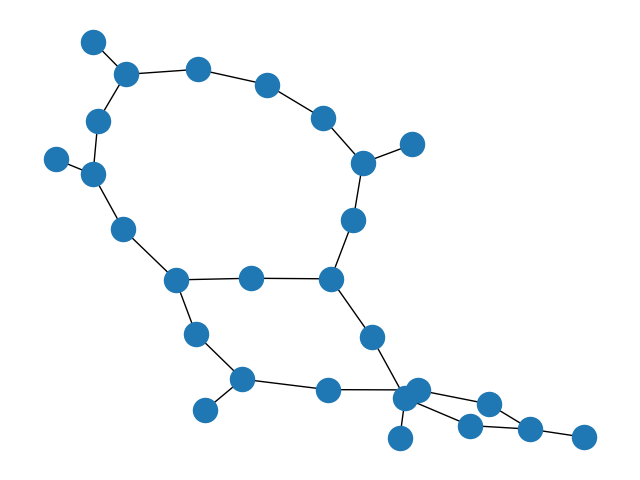

In [5]:
nx.draw(G_device)

# Grouping

In [6]:
def n_groups_shuffle(paulis, G, seed, shuffle_paulis=True, shuffle_qubits=True, x=1, n_max=10000, n_delete=0):
    
    G_new = copy.deepcopy(G)
    
    if x < 1 or n_delete > 0:
        edges = list(G_new.edges())
        
        if x < 1:
            n_delete = int((1 - x) * len(edges))
                    
        indices_delete = np.random.default_rng().choice(len(edges), size=n_delete, replace=False)
        for index in indices_delete:
            G_new.remove_edge(*edges[index])
            
        if not nx.is_connected(G_new):
            if n_max == 0:
#                 print('Graph not connected.')
                return np.nan, None, None, G_new
            else:
                return n_groups_shuffle(paulis, G, seed, shuffle_paulis=shuffle_paulis,
                                        shuffle_qubits=shuffle_qubits, x=x, n_max=n_max - 1, n_delete=n_delete)
    
    np.random.seed(seed)
    order_paulis = np.arange(len(paulis))
    order_qubits = np.arange(num_qubits)
    if shuffle_paulis:
        np.random.shuffle(order_paulis)
        
    if shuffle_qubits:
        np.random.shuffle(order_qubits)
        
        temp = copy.deepcopy(paulis)
        for i in range(len(order_qubits)):
            paulis[:, i] = temp[:, order_qubits[i]]
    
    Groups_HEEM, _, _ = groupingWithOrder(paulis[order_paulis], G_new)
    return len(Groups_HEEM), order_paulis, order_qubits, G_new

In [7]:
backend_parallel = 'multiprocessing'

N = 100

pbar = tqdm(range(N), desc='Shuffling')
results = Parallel(n_jobs=-1, backend=backend_parallel)(
    delayed(n_groups_shuffle)(paulis, G_ideal, None, x=0.25) for i in pbar)

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
n_groups = [results[i][0] for i in range(N)]

delete_indices = np.where(np.isnan(n_groups))[0]
for i, index in enumerate(delete_indices):
    n_groups.pop(index - i)
    results.pop(index - i)

index_min = np.argmin(n_groups)
optimal_paulis_order, optimal_qubit_order, optimal_G = results[index_min][1:4]

results = None

print(len(n_groups))
print(min(n_groups), max(n_groups))

100
49 78


28 7


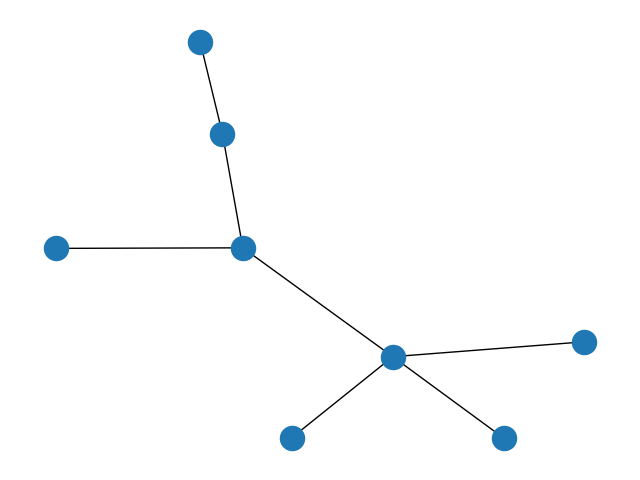

In [95]:
n = num_qubits
k = 2
total_edges = int(np.math.factorial(n) / (np.math.factorial(n - k) * 2))

plt.figure()
nx.draw(optimal_G)
print(total_edges, len(list(optimal_G.edges)))

In [96]:
n_x = 10
N = 100
x_vec = np.linspace((num_qubits - 1) / total_edges, 1, n_x)

n_groups_list = []

for i in tqdm(range(n_x), desc='Connectivity', position=0):
    
    results = Parallel(n_jobs=-1, backend=backend_parallel)(
        delayed(n_groups_shuffle)(paulis, G_ideal, None, x=x_vec[i]) for j in tqdm(range(N), desc='Shuffling', position=1))
    
    n_groups = [results[i][0] for i in range(N)]

    delete_indices = np.where(np.isnan(n_groups))[0]
    for i, index in enumerate(delete_indices):
        n_groups.pop(index - i)

    n_groups_list.append(n_groups)

Connectivity:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling:   0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
n_std = np.zeros(n_x)
n_avg = np.zeros(n_x)
n_min = np.zeros(n_x)
n_max = np.zeros(n_x)

for i in range(n_x):
    print(len(n_groups_list[i]))
    n_std[i] = np.std(n_groups_list[i])
    n_avg[i] = np.mean(n_groups_list[i])
    n_min[i] = np.min(n_groups_list[i])
    n_max[i] = np.max(n_groups_list[i])

100
100
100
100
100
100
100
100
100
100


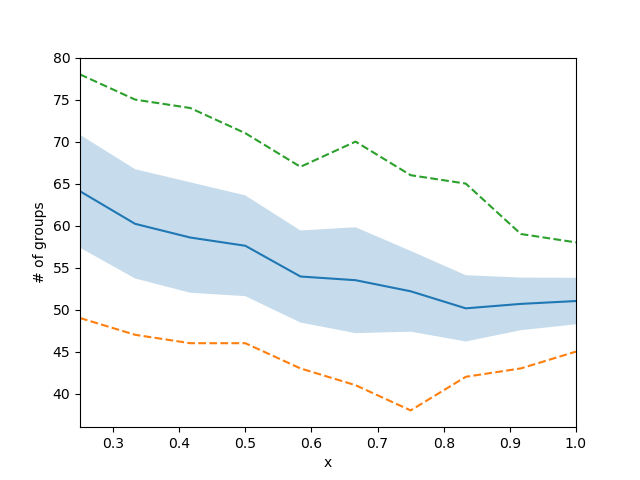

In [99]:
fig, ax = plt.subplots()

ax.plot(x_vec, n_avg)
ax.fill_between(x_vec, n_avg - n_std, n_avg + n_std, alpha=0.25)
ax.plot(x_vec, n_min, '--')
ax.plot(x_vec, n_max, '--')
ax.set_xlabel('x')
ax.set_ylabel('# of groups')
ax.set_xlim([x_vec[0], x_vec[-1]]);

# Compute VQE

In [14]:
# paulis_order = np.arange(len(paulis))
# qubit_order = np.arange(num_qubits)
paulis_order = optimal_paulis_order
qubit_order = optimal_qubit_order

new_qubit_op = change_order_qubitop(qubit_op, paulis_order, qubit_order)

In [17]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
print(result_exact.eigenvalue)

result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(new_qubit_op)
print(result_exact.eigenvalue)

(-13.917723466689248-1.5385124673163216e-15j)
(-13.917723466689239+3.86895453536616e-16j)


In [26]:
def callback( evals, params, energy, extra):  
    display("{}, {}".format(evals, energy))
    clear_output(wait=True)

entangled_layer = []
for qbs in WC_device :
    if qbs[0] < qbs[1] and qbs[1] < num_qubits :
        entangled_layer.append(qbs)

init_state = QuantumCircuit(num_qubits)
        
ansatz = init_state.compose(EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1))

num_var = ansatz.num_parameters
pars = [0.01] * num_var

optimizer = COBYLA(maxiter=10)

In [31]:
# qi = QuantumInstance(backend_sim, shots = NUM_SHOTS)
solver = VQE(ansatz, optimizer, pars, grouping='Entangled', callback=callback,
             connectivity = WC_device)
results = solver.compute_minimum_eigenvalue(new_qubit_op)
print(results.eigenvalue)

-9.929401796461347


In [30]:
solver.number_circuits()

49